Evaluate connectome as networks with the experimental weights directly (instead of only using mask).  
Normalize weights by sum of incoming weights.

In [36]:
from functools import partial
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
#from imports_paper_plots import *

from echoes import ESNRegressor

from bioRNN.tasks.memory.capacity import make_X_y, forgetting
from bioRNN.utils import make_bioRRNs, load_connectome

#set_context_and_font()
#set_rcParams_color()

In [14]:
def forgetting_R2(y_true, y_pred):
    assert y_pred.shape == y_true.shape, "y_pred and y_true must have same shape"
    assert y_pred.shape[0] > 1, "Error while computing forgetting: y_pred has less than 1 sample. Increase the number of samples (steps)"
    r2s = []
    for true, pred in zip(y_true.T, y_pred.T):        
        r2s.append(r2_score(true, pred))
    return r2s, np.sum(r2s)    

In [102]:
lags=np.arange(1, 16)
X, y = make_X_y(
    make_X=partial(np.random.uniform, low=-.5, high=.5, size=5_000),
    lags=lags,
    cut=0
)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4000, 1), (1000, 1), (4000, 15), (1000, 15))

In [103]:
from sklearn.preprocessing import normalize, scale

In [168]:
W = make_bioRRNs(connectome_name="macaque", rand_partition=True, neuron_density=1)["W_bio_rank"]

W = np.random.lognormal(size=W.shape)
W = np.random.exponential(size=W.shape)
W = np.random.zipf(1.5, size=W.shape) * .00001

(array([431., 197.,  90.,  52.,  27.,  17.,  16.,   7.,   2.,   2.]),
 array([-5.        , -4.54021952, -4.08043903, -3.62065855, -3.16087806,
        -2.70109758, -2.24131709, -1.78153661, -1.32175613, -0.86197564,
        -0.40219516]),
 <BarContainer object of 10 artists>)

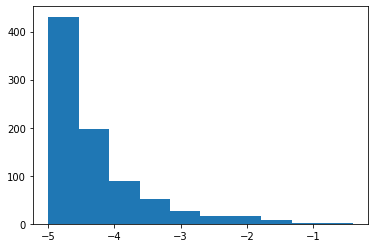

In [169]:
#plt.hist(np.log10(W.flat))
plt.hist(np.log10(W.flat))
#plt.xscale("log")
#plt.yscale("log")

In [170]:
W.dtype

dtype('float64')

In [171]:
#W = load_connectome("macaque")
#W = np.array([row / row.sum() for row in W.T])

n_transient = 100
y_pred = (ESNRegressor(W=W,
                       n_transient=n_transient, 
                       spectral_radius=.99,
                       input_scaling=.01,)
          .fit(X_train, y_train)
          .predict(X_test))

forget_curve, mc = forgetting(y_test[n_transient:], y_pred[n_transient:])
forget_curve_2, mc2 = forgetting_R2(y_test[n_transient:], y_pred[n_transient:])

5.241611050155623 5.141651356181775


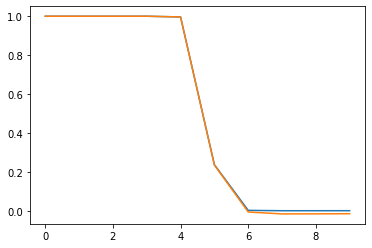

In [172]:
plt.plot(forget_curve[:10])
plt.plot(forget_curve_2[:10])
print(mc, mc2)